<a href="https://colab.research.google.com/github/YutakaOsaki/ouenka-colab/blob/main/model_ouenka_fp_angle.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install ffmpeg-python pydub soundfile

In [ ]:
# 音声処理＆可視化に必要なライブラリをインストール
!pip install -q librosa ffmpeg-python

# ffmpegが必要なMP3のデコードをサポート
!apt-get install -y ffmpeg

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
ffmpeg is already the newest version (7:4.4.2-0ubuntu0.22.04.1).
0 upgraded, 0 newly installed, 0 to remove and 35 not upgraded.
Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
ffmpeg is already the newest version (7:4.4.2-0ubuntu0.22.04.1).
0 upgraded, 0 newly installed, 0 to remove and 35 not upgraded.


In [ ]:
import librosa
import librosa.display
import matplotlib.pyplot as plt
import numpy as np
from IPython.display import Audio, display
from scipy.ndimage import maximum_filter, uniform_filter
from scipy.signal import convolve2d
from scipy.ndimage import label, find_objects
import matplotlib.patches as patches
from skimage import measure

# Preprocessing

In [ ]:
import numpy as np
import librosa
from scipy.signal import convolve2d

def compute_fp_and_ridges(audio_path,
                          t_start=0.0, duration=10.0,
                          fmin=2000, fmax=3500,
                          grid_shape=(30, 100),
                          n_fft=2048, hop_length=512,
                          ridge_tol=2, min_len=20,
                          use_sigmoid=True):
    """リッジ列抽出と角度グリッド計算を 1 本の関数で行う"""
    # --------------------------------------------------
    # 1. 音声ロード & STFT
    # --------------------------------------------------
    y, sr = librosa.load(audio_path, sr=None, mono=True)
    y = y[int(t_start * sr): int((t_start + duration) * sr)]

    S     = librosa.stft(y, n_fft=n_fft, hop_length=hop_length)
    S_db  = librosa.amplitude_to_db(np.abs(S), ref=np.max)
    freqs = librosa.fft_frequencies(sr=sr, n_fft=n_fft)

    # --------------------------------------------------
    # 2. 指定帯域のスペクトログラム差分
    # --------------------------------------------------
    mask   = (freqs >= fmin) & (freqs <= fmax)
    S_band = S_db[mask]                                # (bins × frames)
    S_norm = (S_band - S_band.mean()) / (S_band.std() + 1e-9) * np.sqrt(2)
    S_blur = convolve2d(S_norm, np.ones((30, 15)) / 450, mode="same", boundary="symm")
    S_diff = S_norm - S_blur

    # --------------------------------------------------
    # 3. リッジ抽出
    # --------------------------------------------------
    peak_mask = librosa.util.localmax(S_diff) & (S_diff > 0)
    peaks     = np.argwhere(peak_mask)
    peaks     = peaks[np.argsort(peaks[:, 1])]          # frame 順

    ridges, active = [], []                             # active: [last_frame, last_bin, pts]
    for bin_, frame in peaks:
        attached = False
        for tr in active:
            last_f, last_bin, pts = tr
            if frame == last_f + 1 and abs(bin_ - last_bin) <= ridge_tol:
                tr[0], tr[1] = frame, bin_
                pts.append((frame, bin_))
                attached = True
                break
        if not attached:
            active.append([frame, bin_, [(frame, bin_)]])
        # 1 フレーム以上空いた軌跡を確定
        for tr in active[:]:
            if frame > tr[0] + 1:
                if len(tr[2]) >= min_len:
                    ridges.append(tr[2])
                active.remove(tr)
    # 終端処理
    for tr in active:
        if len(tr[2]) >= min_len:
            ridges.append(tr[2])

    # --------------------------------------------------
    # 4. 角度グリッド計算（インライン化部分）
    # --------------------------------------------------
    rows, cols = grid_shape
    sum_angle = np.zeros((rows, cols), np.float32)
    hits      = np.zeros((rows, cols), np.int32)

    cell_hz  = (fmax - fmin) / rows
    cell_sec = duration / cols

    freq_band = freqs[mask]

    for pts in ridges:
        # 時間 (s) と周波数 (Hz) へ変換
        t = np.array([p[0] * hop_length / sr for p in pts])
        f = np.array([freq_band[p[1]] for p in pts])

        # グリッド座標
        col = np.clip((t / duration * cols).astype(int),                0, cols - 1)
        row = np.clip(((f - fmin) / (fmax - fmin) * rows).astype(int),  0, rows - 1)

        # セル単位の角度を集計
        for k in range(len(col) - 1):
            c, r  = col[k], row[k]
            dt, df = t[k + 1] - t[k], f[k + 1] - f[k]
            if dt == 0:
                continue
            x = (df / cell_hz) / (dt / cell_sec)

            val = (2 / (1 + np.exp(-1.2 * x)) - 1) * 100 + 200
            sum_angle[r, c] += int(val)
            hits[r, c]      += 1

    fp_angle = np.divide(sum_angle, hits, where=hits > 0)
    fp_angle[hits == 0] = 0.0

    # --------------------------------------------------
    # 5. 出力
    # --------------------------------------------------
    return fp_angle.astype(np.float32, copy=False), ridges, S_diff, freq_band, sr

# import dataset

In [ ]:
import numpy as np
import os, glob
from keras.utils import to_categorical
from typing import Union

def merge_label_npz(*paths: Union[str, list, tuple]):
    """
    ラベル別に保存した .npz 群をまとめて結合し、
    X, y_labels, y_indices, y_categorical を返す。

    Parameters
    ----------
    *paths : 可変長
        ・ディレクトリパス            → その直下の *.npz を全取得
        ・ファイルパス列              → そのファイルだけ結合
        ・リスト/タプル 1 つ           → 中身を展開して処理

    Returns
    -------
    X              : np.ndarray   (N, D)
    y_labels       : list[str]    一意ラベル (昇順)
    y_indices      : np.ndarray   (N,)
    y_categorical  : np.ndarray   (N, C) 1-hot
    """
    # ---------- ① 入力の正規化 ----------
    if len(paths) == 1 and isinstance(paths[0], (list, tuple)):
        paths = paths[0]                            # リスト 1 個なら展開

    npz_files = []
    for p in paths:
        if os.path.isdir(p):
            npz_files.extend(glob.glob(os.path.join(p, "*.npz")))
        else:
            npz_files.append(p)

    if not npz_files:
        raise FileNotFoundError("指定されたパスに .npz が見つかりません")

    # ---------- ② 読み込み ----------
    X_buf, label_buf = [], []

    for fp in sorted(npz_files):
        data = np.load(fp, allow_pickle=True)
        if "X" not in data:
            raise KeyError(f"{fp} に 'X' が見当たりません")

        X_part = data["X"]

        # ------ ラベル情報の取り出し ------
        if "y_labels" in data:              # 旧：まとめ保存
            labels_part = data["y_labels"].tolist()
        elif "y_label" in data:             # 新：1 ラベル保存
            labels_part = data["y_label"].tolist()
        else:
            raise KeyError(f"{fp} にラベル情報が見当たりません")

        # 1 ラベル保存なら X 全要素に同一ラベルを付与
        if len(labels_part) == 1 and len(X_part) > 1:
            labels_part = labels_part * len(X_part)

        X_buf.append(X_part)
        label_buf.extend(labels_part)

    # ---------- ③ マージ ----------
    X = np.vstack(X_buf).astype(np.float32)
    y_labels = sorted(set(label_buf))
    y_indices = np.array([y_labels.index(lbl) for lbl in label_buf], dtype=np.int32)
    y_categorical = to_categorical(y_indices, num_classes=len(y_labels))

    return X, y_labels, y_indices, y_categorical

X, y_labels, y_indices, y_categorical = merge_label_npz(
    "/content/drive/MyDrive/classifier-ouenka/classifier_ouenka/database/20250710-fpangle"
)

In [ ]:
print(X.shape)
print(y_labels)
print(y_indices.shape)
print(y_categorical.shape)

(20000, 30, 100)
['akahane', 'aoki', 'chance5', 'commontheme', 'murakami', 'namiki', 'nishikawa', 'ozuna', 'santana', 'yamada']
(20000,)
(20000, 10)


# Tensorflow

In [ ]:
import numpy as np
import os
import librosa
import librosa.display
import matplotlib.pyplot as plt
from skimage import measure
import seaborn as sns
from tqdm import tqdm
import random
import tensorflow as tf

from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Model
from tensorflow.keras.layers import (Input, Dense, Dropout, Add, ReLU,
                                     Concatenate, Lambda, LSTM)
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import (Input, Conv2D, BatchNormalization, ReLU,
                                     Add, Dropout, Permute, Reshape,
                                     Bidirectional, LSTM, Dense)


# ----------------------------------------------------------
def resnet_cnn_block(x, filters, kernel_size=(3, 3), drop=0.1):
    """2-D Conv Residual block wrapped in Keras layers."""
    shortcut = x
    x = Conv2D(filters, kernel_size, padding="same", use_bias=False)(x)
    x = BatchNormalization()(x)
    x = ReLU()(x)

    x = Conv2D(filters, kernel_size, padding="same", use_bias=False)(x)
    x = BatchNormalization()(x)

    # チャンネル数が違う場合は 1×1 Conv で合わせる
    if shortcut.shape[-1] != filters:
        shortcut = Conv2D(filters, (1, 1), padding="same", use_bias=False)(shortcut)

    x = Add()([shortcut, x])
    x = ReLU()(x)
    x = Dropout(drop)(x)
    return x
# ----------------------------------------------------------

from tensorflow.keras.layers import (
    Input, Reshape, Conv2D, SeparableConv2D,
    BatchNormalization, ReLU, MaxPool2D,
    Permute, Reshape, GRU,
    Dense, Dropout, GlobalAveragePooling2D
)
from tensorflow.keras.models import Model

def build_cnn_gru_large_model(freq_bins=30, time_steps=100, n_classes=10):
    inp = Input(shape=(freq_bins, time_steps))          # (30,100)
    x = Reshape((freq_bins, time_steps, 1))(inp)        # (30,100,1)

    # --- 超大型 CNN ブロック ---
    x = Conv2D(128, (3,3), padding='same', use_bias=False)(x)
    x = BatchNormalization()(x)
    x = ReLU()(x)
    x = MaxPool2D((2,2))(x)                             # → (15,50,128)

    x = SeparableConv2D(256, (3,3), padding='same', use_bias=False)(x)
    x = BatchNormalization()(x)
    x = ReLU()(x)
    x = MaxPool2D((2,2))(x)                             # → (7,25,256)

    x = SeparableConv2D(512, (3,3), padding='same', use_bias=False)(x)
    x = BatchNormalization()(x)
    x = ReLU()(x)
    # 時系列長をキープ → (7,25,512)

    # --- 時系列処理用に整形 & 大型 GRU ---
    x = Permute((2,1,3))(x)                             # → (25,7,512)
    x = Reshape((time_steps//4, 7*512))(x)              # → (25,3584)
    x = GRU(256, dropout=0.2, recurrent_dropout=0.0)(x)  # → (256,)

    # --- Dense Head ---
    x = Dense(512, activation='relu')(x)
    x = Dropout(0.5)(x)
    out = Dense(n_classes, activation='softmax')(x)

    model = Model(inp, out)
    model.compile(
        optimizer='adam',
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )
    return model

# 構築例
model = build_cnn_gru_large_model(
    freq_bins=30,
    time_steps=100,
    n_classes=len(y_labels)
)
model.summary(line_length=120)


Model: "functional_9"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━
┃ Layer (type)                                        ┃ Output Shape                           ┃               Para
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━
│ input_layer_9 (InputLayer)                          │ (None, 30, 100)                        │                   
├─────────────────────────────────────────────────────┼────────────────────────────────────────┼───────────────────
│ reshape_13 (Reshape)                                │ (None, 30, 100, 1)                     │                   
├─────────────────────────────────────────────────────┼────────────────────────────────────────┼───────────────────
│ conv2d_37 (Conv2D)                                  │ (None, 30, 100, 128)                   │                 1,
├─────────────────────────────────────────────────────┼────────────────────────────────────────┼───────────────────
│ batch_normalization_39 (BatchNormalization)         │ (None, 30, 100, 128)                   │                   
├─────────────────────────────────────────────────────┼────────────────────────────────────────┼───────────────────
│ re_lu_39 (ReLU)                                     │ (None, 30, 100, 128)                   │                   
├─────────────────────────────────────────────────────┼────────────────────────────────────────┼───────────────────
│ max_pooling2d_12 (MaxPooling2D)                     │ (None, 15, 50, 128)                    │                   
├─────────────────────────────────────────────────────┼────────────────────────────────────────┼───────────────────
│ separable_conv2d_10 (SeparableConv2D)               │ (None, 15, 50, 256)                    │                33,
├─────────────────────────────────────────────────────┼────────────────────────────────────────┼───────────────────
│ batch_normalization_40 (BatchNormalization)         │ (None, 15, 50, 256)                    │                 1,
├─────────────────────────────────────────────────────┼────────────────────────────────────────┼───────────────────
│ re_lu_40 (ReLU)                                     │ (None, 15, 50, 256)                    │                   
├─────────────────────────────────────────────────────┼────────────────────────────────────────┼───────────────────
│ max_pooling2d_13 (MaxPooling2D)                     │ (None, 7, 25, 256)                     │                   
├─────────────────────────────────────────────────────┼────────────────────────────────────────┼───────────────────
│ separable_conv2d_11 (SeparableConv2D)               │ (None, 7, 25, 512)                     │               133,
├─────────────────────────────────────────────────────┼────────────────────────────────────────┼───────────────────
│ batch_normalization_41 (BatchNormalization)         │ (None, 7, 25, 512)                     │                 2,
├─────────────────────────────────────────────────────┼────────────────────────────────────────┼───────────────────
│ re_lu_41 (ReLU)                                     │ (None, 7, 25, 512)                     │                   
├─────────────────────────────────────────────────────┼────────────────────────────────────────┼───────────────────
│ permute_5 (Permute)                                 │ (None, 25, 7, 512)                     │                   
├─────────────────────────────────────────────────────┼────────────────────────────────────────┼───────────────────
│ reshape_14 (Reshape)                                │ (None, 25, 3584)                       │                   
├─────────────────────────────────────────────────────┼────────────────────────────────────────┼───────────────────
│ gru_4 (GRU)                                         │ (None, 256)                            │             2,950,
├─────────────────────────────────────────────────────┼─

 Total params: 3,259,402 (12.43 MB)

 Trainable params: 3,257,610 (12.43 MB)

 Non-trainable params: 1,792 (7.00 KB)

In [ ]:
# --- 学習データ分割 ---
X_train, X_test, y_train, y_test = train_test_split(X, y_categorical, test_size=0.2, random_state=42)

# --- 学習 ---
history = model.fit(
    X_train, y_train,
    epochs=10,
    batch_size=32,
    validation_data=(X_test, y_test),
)

# --- 評価 ---
test_loss, test_acc = model.evaluate(X_test, y_test, verbose=0)
print(f"\n✅ Test Accuracy: {test_acc:.2%}")
print("📘 Labels:", y_labels)

# --- モデル保存 ---
model.save("/content/model_res_filtered.keras")
print("💾 モデルを保存しました。")

Epoch 1/10
500/500 ━━━━━━━━━━━━━━━━━━━━ 299s 580ms/step - accuracy: 0.3895 - loss: 1.7088 - val_accuracy: 0.7803 - val_loss: 0.6242
Epoch 2/10
500/500 ━━━━━━━━━━━━━━━━━━━━ 291s 582ms/step - accuracy: 0.8840 - loss: 0.3501 - val_accuracy: 0.9460 - val_loss: 0.1828
Epoch 3/10
500/500 ━━━━━━━━━━━━━━━━━━━━ 288s 577ms/step - accuracy: 0.9416 - loss: 0.1743 - val_accuracy: 0.9400 - val_loss: 0.1765
Epoch 4/10
500/500 ━━━━━━━━━━━━━━━━━━━━ 287s 575ms/step - accuracy: 0.9695 - loss: 0.0950 - val_accuracy: 0.9663 - val_loss: 0.0944
Epoch 5/10
500/500 ━━━━━━━━━━━━━━━━━━━━ 281s 562ms/step - accuracy: 0.9766 - loss: 0.0718 - val_accuracy: 0.9550 - val_loss: 0.1310
Epoch 6/10
500/500 ━━━━━━━━━━━━━━━━━━━━ 284s 567ms/step - accuracy: 0.9784 - loss: 0.0673 - val_accuracy: 0.9697 - val_loss: 0.0969
Epoch 7/10
500/500 ━━━━━━━━━━━━━━━━━━━━ 281s 562ms/step - accuracy: 0.9784 - loss: 0.0674 - val_accuracy: 0.9803 - val_loss: 0.0656
Epoch 8/10
500/500 ━━━━━━━━━━━━━━━━━━━━ 280s 560ms/step - accuracy: 0.9871 -

model: 74%
model_res: 71%

# TEST


🎧 Evaluating: akahane-playing-5.mp3
🟢：akahane,	predicted=akahane,	{akahane: 1.00, namiki: 0.00, nishikawa: 0.00, ozuna: 0.00, chance5: 0.00, aoki: 0.00, commontheme: 0.00, murakami: 0.00, yamada: 0.00, santana: 0.00},	0.0
🟢：akahane,	predicted=akahane,	{akahane: 1.00, namiki: 0.00, chance5: 0.00, nishikawa: 0.00, commontheme: 0.00, aoki: 0.00, yamada: 0.00, ozuna: 0.00, murakami: 0.00, santana: 0.00},	0.7469310657596373
🟢：akahane,	predicted=akahane,	{akahane: 1.00, chance5: 0.00, namiki: 0.00, commontheme: 0.00, yamada: 0.00, nishikawa: 0.00, aoki: 0.00, ozuna: 0.00, murakami: 0.00, santana: 0.00},	1.4938621315192746
🟢：akahane,	predicted=akahane,	{akahane: 1.00, namiki: 0.00, chance5: 0.00, commontheme: 0.00, ozuna: 0.00, nishikawa: 0.00, yamada: 0.00, aoki: 0.00, murakami: 0.00, santana: 0.00},	2.240793197278912
🟢：akahane,	predicted=akahane,	{akahane: 1.00, namiki: 0.00, nishikawa: 0.00, chance5: 0.00, ozuna: 0.00, yamada: 0.00, santana: 0.00, commontheme: 0.00, aoki: 0.00, murakami: 

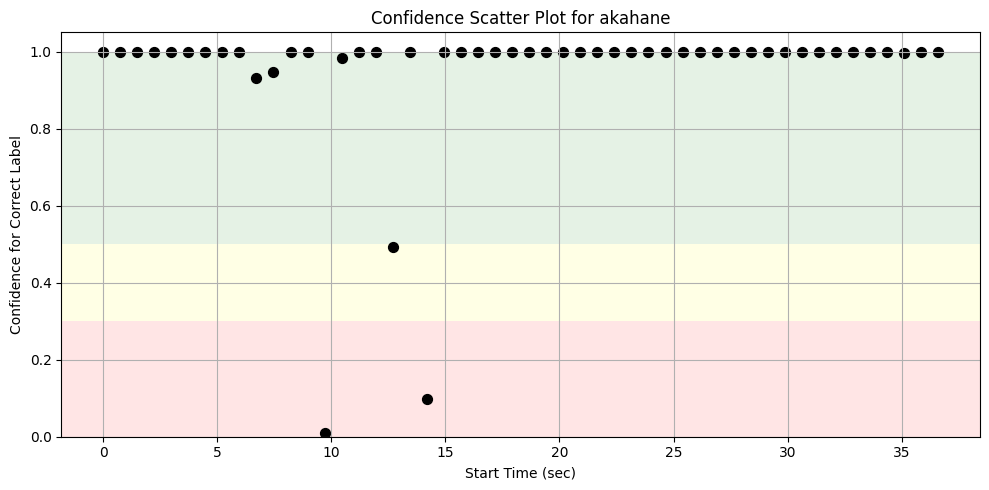

Accuracy (akahane)：94.0 %

🎧 Evaluating: aoki-playing-5.mp3
🟡：aoki,	predicted=yamada,	{yamada: 0.78, aoki: 0.13, murakami: 0.08, ozuna: 0.01, commontheme: 0.00, nishikawa: 0.00, namiki: 0.00, chance5: 0.00, santana: 0.00, akahane: 0.00},	0.0
🟢：aoki,	predicted=aoki,	{aoki: 0.48, yamada: 0.45, murakami: 0.03, ozuna: 0.02, commontheme: 0.00, nishikawa: 0.00, namiki: 0.00, akahane: 0.00, chance5: 0.00, santana: 0.00},	0.6295814058956916
🔴：aoki,	predicted=yamada,	{yamada: 0.99, murakami: 0.00, aoki: 0.00, namiki: 0.00, commontheme: 0.00, chance5: 0.00, santana: 0.00, ozuna: 0.00, nishikawa: 0.00, akahane: 0.00},	1.2591628117913831
🟢：aoki,	predicted=aoki,	{aoki: 0.99, murakami: 0.01, yamada: 0.00, chance5: 0.00, commontheme: 0.00, nishikawa: 0.00, namiki: 0.00, santana: 0.00, akahane: 0.00, ozuna: 0.00},	1.8887442176870746
🟡：aoki,	predicted=murakami,	{murakami: 0.75, aoki: 0.19, namiki: 0.05, chance5: 0.01, commontheme: 0.00, yamada: 0.00, santana: 0.00, nishikawa: 0.00, akahane: 0.00, ozuna

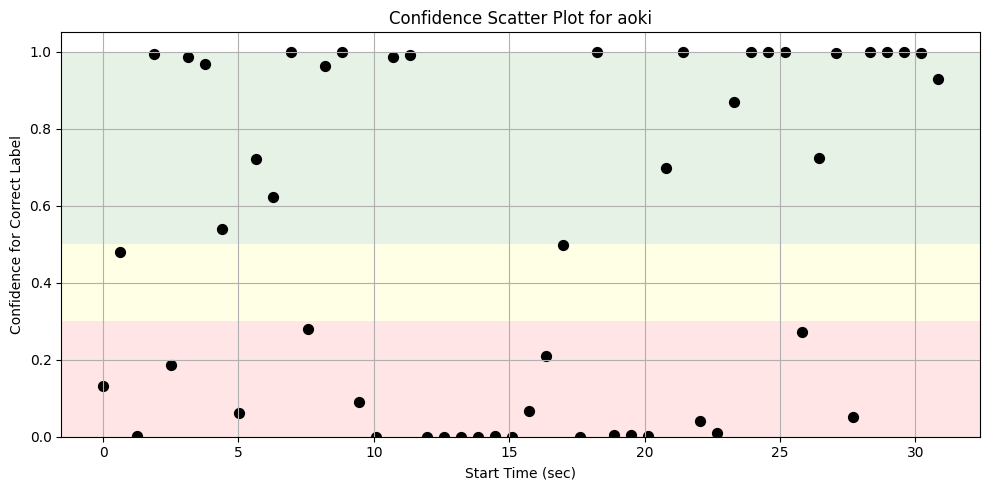

Accuracy (aoki)：54.0 %

🎧 Evaluating: chance5-playing-5.mp3
🟢：chance5,	predicted=chance5,	{chance5: 1.00, yamada: 0.00, murakami: 0.00, namiki: 0.00, nishikawa: 0.00, santana: 0.00, commontheme: 0.00, aoki: 0.00, akahane: 0.00, ozuna: 0.00},	0.0
🟡：chance5,	predicted=nishikawa,	{nishikawa: 0.65, chance5: 0.29, murakami: 0.06, commontheme: 0.00, akahane: 0.00, yamada: 0.00, namiki: 0.00, ozuna: 0.00, santana: 0.00, aoki: 0.00},	1.3007251700680271
🟢：chance5,	predicted=chance5,	{chance5: 1.00, nishikawa: 0.00, murakami: 0.00, commontheme: 0.00, yamada: 0.00, akahane: 0.00, namiki: 0.00, ozuna: 0.00, aoki: 0.00, santana: 0.00},	2.6014503401360543
🟢：chance5,	predicted=chance5,	{chance5: 1.00, nishikawa: 0.00, murakami: 0.00, commontheme: 0.00, yamada: 0.00, akahane: 0.00, aoki: 0.00, namiki: 0.00, ozuna: 0.00, santana: 0.00},	3.9021755102040814
🟢：chance5,	predicted=chance5,	{chance5: 1.00, commontheme: 0.00, murakami: 0.00, akahane: 0.00, aoki: 0.00, yamada: 0.00, nishikawa: 0.00, namiki: 0.

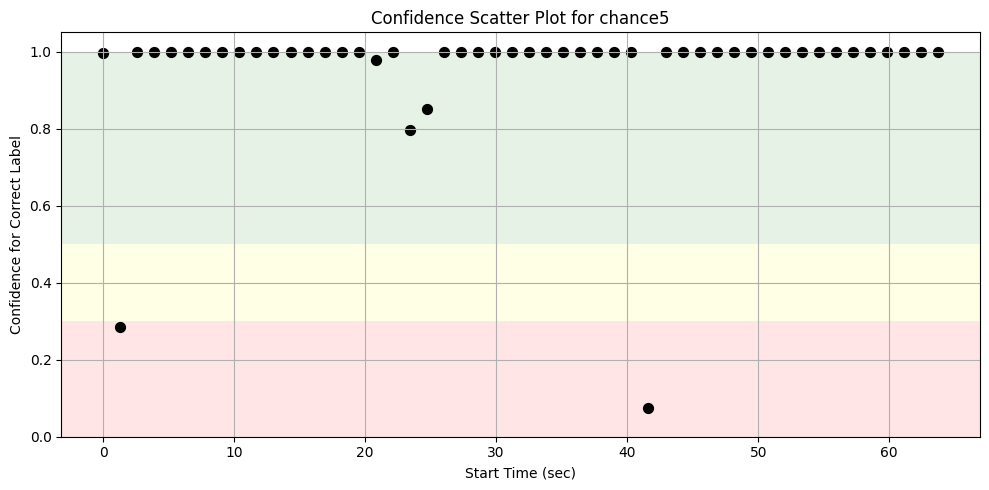

Accuracy (chance5)：96.0 %

🎧 Evaluating: commontheme-playing-5.mp3
🟢：commontheme,	predicted=commontheme,	{commontheme: 1.00, ozuna: 0.00, murakami: 0.00, aoki: 0.00, akahane: 0.00, chance5: 0.00, yamada: 0.00, nishikawa: 0.00, namiki: 0.00, santana: 0.00},	0.0
🟢：commontheme,	predicted=commontheme,	{commontheme: 1.00, akahane: 0.00, ozuna: 0.00, aoki: 0.00, yamada: 0.00, murakami: 0.00, chance5: 0.00, namiki: 0.00, nishikawa: 0.00, santana: 0.00},	0.9736766439909297
🟢：commontheme,	predicted=commontheme,	{commontheme: 1.00, chance5: 0.00, akahane: 0.00, yamada: 0.00, ozuna: 0.00, aoki: 0.00, murakami: 0.00, namiki: 0.00, santana: 0.00, nishikawa: 0.00},	1.9473532879818594
🟢：commontheme,	predicted=commontheme,	{commontheme: 1.00, yamada: 0.00, ozuna: 0.00, chance5: 0.00, akahane: 0.00, aoki: 0.00, murakami: 0.00, namiki: 0.00, santana: 0.00, nishikawa: 0.00},	2.921029931972789
🟢：commontheme,	predicted=commontheme,	{commontheme: 1.00, murakami: 0.00, chance5: 0.00, aoki: 0.00, yamada: 0.00

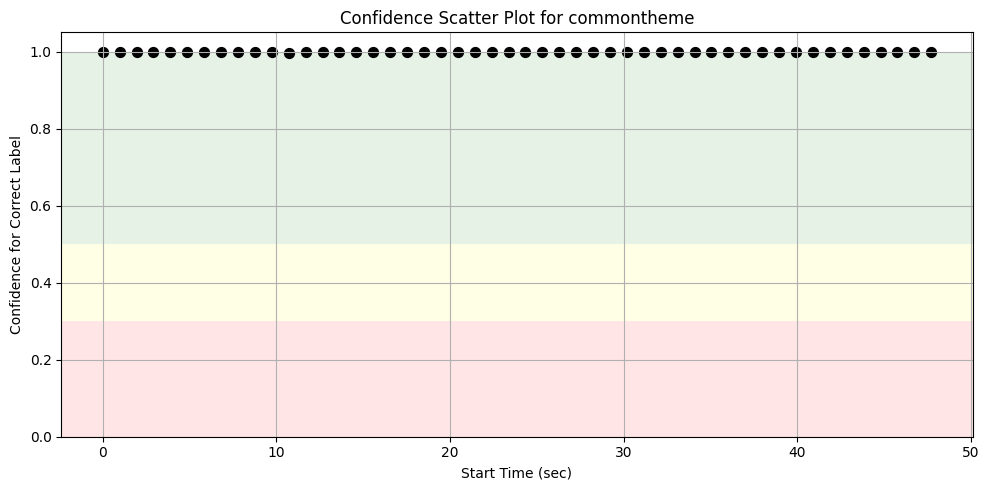

Accuracy (commontheme)：100.0 %

🎧 Evaluating: murakami-playing-5.mp3
🟢：murakami,	predicted=murakami,	{murakami: 0.69, nishikawa: 0.30, ozuna: 0.01, yamada: 0.00, aoki: 0.00, commontheme: 0.00, chance5: 0.00, akahane: 0.00, namiki: 0.00, santana: 0.00},	0.0
🟢：murakami,	predicted=murakami,	{murakami: 0.75, yamada: 0.24, aoki: 0.01, chance5: 0.00, nishikawa: 0.00, namiki: 0.00, santana: 0.00, ozuna: 0.00, commontheme: 0.00, akahane: 0.00},	1.1912
🟢：murakami,	predicted=murakami,	{murakami: 0.79, aoki: 0.21, yamada: 0.00, chance5: 0.00, santana: 0.00, namiki: 0.00, ozuna: 0.00, commontheme: 0.00, nishikawa: 0.00, akahane: 0.00},	2.3824
🟡：murakami,	predicted=yamada,	{yamada: 0.98, murakami: 0.02, aoki: 0.00, ozuna: 0.00, santana: 0.00, namiki: 0.00, chance5: 0.00, nishikawa: 0.00, commontheme: 0.00, akahane: 0.00},	3.5736
🟡：murakami,	predicted=commontheme,	{commontheme: 0.80, yamada: 0.19, murakami: 0.01, ozuna: 0.00, aoki: 0.00, nishikawa: 0.00, chance5: 0.00, santana: 0.00, akahane: 0.00, 

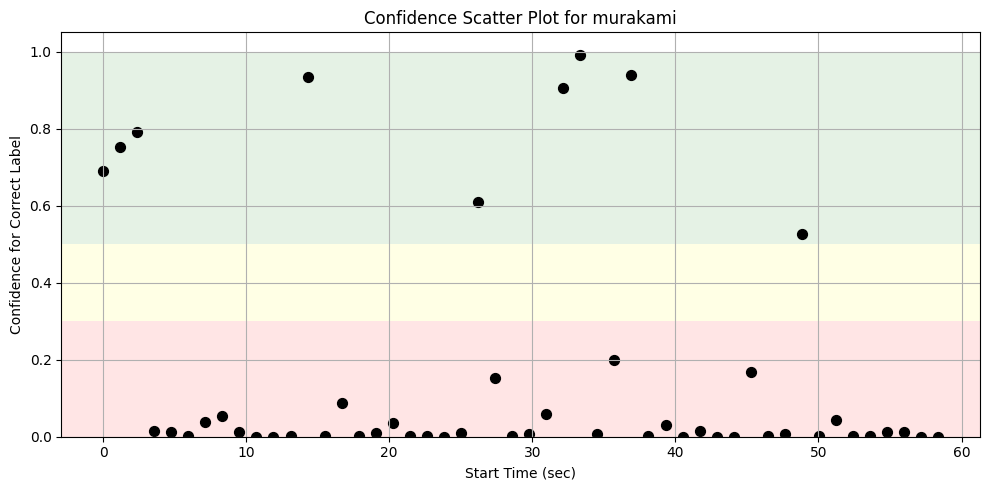

Accuracy (murakami)：18.0 %

🎧 Evaluating: namiki-playing-5.mp3
🟢：namiki,	predicted=namiki,	{namiki: 1.00, aoki: 0.00, murakami: 0.00, nishikawa: 0.00, akahane: 0.00, yamada: 0.00, chance5: 0.00, santana: 0.00, ozuna: 0.00, commontheme: 0.00},	0.0
🔴：namiki,	predicted=commontheme,	{commontheme: 0.68, aoki: 0.28, ozuna: 0.02, akahane: 0.01, chance5: 0.00, yamada: 0.00, santana: 0.00, nishikawa: 0.00, namiki: 0.00, murakami: 0.00},	0.8198879818594105
🟢：namiki,	predicted=namiki,	{namiki: 0.98, akahane: 0.01, yamada: 0.01, chance5: 0.00, commontheme: 0.00, santana: 0.00, aoki: 0.00, murakami: 0.00, nishikawa: 0.00, ozuna: 0.00},	1.639775963718821
🟢：namiki,	predicted=namiki,	{namiki: 0.68, akahane: 0.20, chance5: 0.04, nishikawa: 0.02, ozuna: 0.02, aoki: 0.01, santana: 0.01, murakami: 0.00, yamada: 0.00, commontheme: 0.00},	2.4596639455782316
🟡：namiki,	predicted=murakami,	{murakami: 0.50, namiki: 0.23, chance5: 0.08, santana: 0.07, nishikawa: 0.06, commontheme: 0.04, yamada: 0.01, aoki: 0.01,

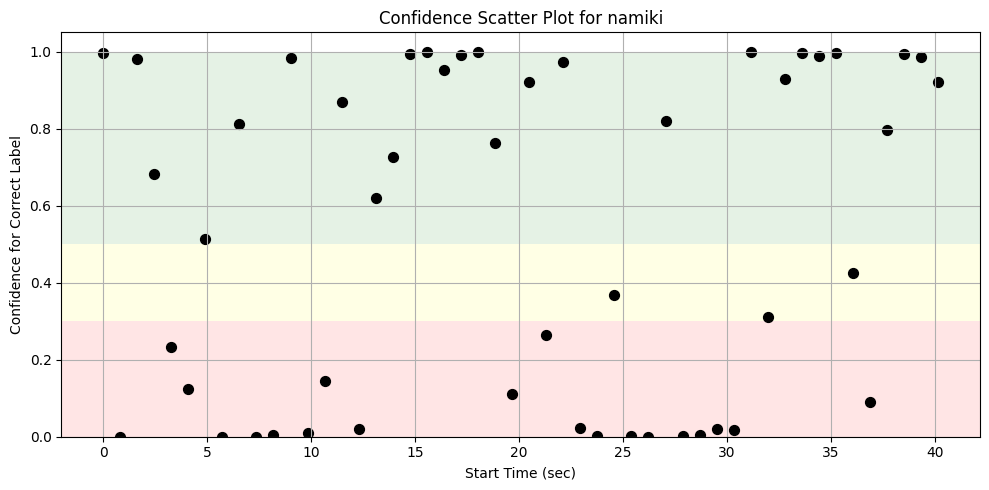

Accuracy (namiki)：54.0 %

🎧 Evaluating: nishikawa-playing-5.mp3
🟢：nishikawa,	predicted=nishikawa,	{nishikawa: 0.97, ozuna: 0.03, santana: 0.00, chance5: 0.00, aoki: 0.00, murakami: 0.00, namiki: 0.00, akahane: 0.00, yamada: 0.00, commontheme: 0.00},	0.0
🟢：nishikawa,	predicted=nishikawa,	{nishikawa: 0.93, ozuna: 0.07, santana: 0.00, yamada: 0.00, aoki: 0.00, akahane: 0.00, chance5: 0.00, murakami: 0.00, namiki: 0.00, commontheme: 0.00},	0.8518380952380953
🟢：nishikawa,	predicted=nishikawa,	{nishikawa: 1.00, ozuna: 0.00, santana: 0.00, akahane: 0.00, chance5: 0.00, murakami: 0.00, aoki: 0.00, namiki: 0.00, yamada: 0.00, commontheme: 0.00},	1.7036761904761906
🟢：nishikawa,	predicted=nishikawa,	{nishikawa: 1.00, ozuna: 0.00, akahane: 0.00, namiki: 0.00, chance5: 0.00, murakami: 0.00, yamada: 0.00, santana: 0.00, aoki: 0.00, commontheme: 0.00},	2.5555142857142856
🟢：nishikawa,	predicted=nishikawa,	{nishikawa: 1.00, ozuna: 0.00, namiki: 0.00, akahane: 0.00, santana: 0.00, murakami: 0.00, chance

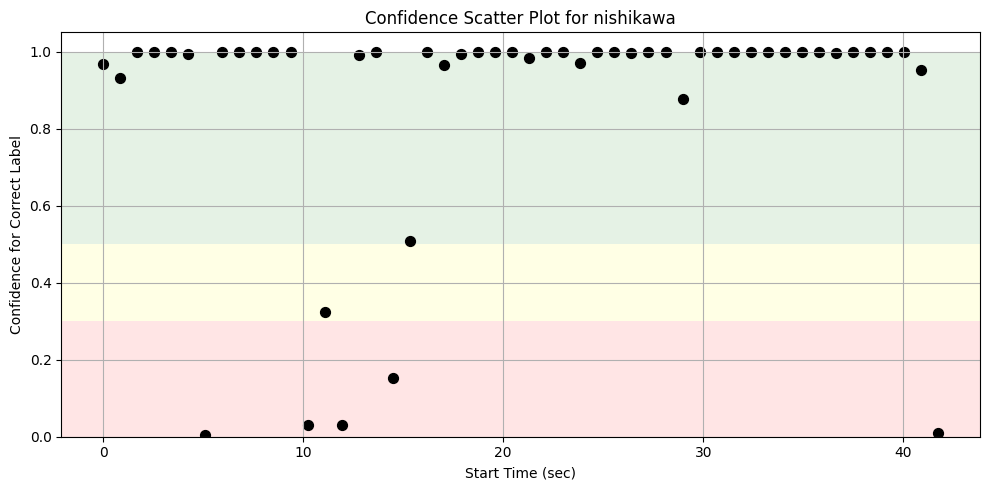

Accuracy (nishikawa)：88.0 %

🎧 Evaluating: ozuna-playing-5.mp3
🟡：ozuna,	predicted=murakami,	{murakami: 0.96, ozuna: 0.04, nishikawa: 0.00, aoki: 0.00, namiki: 0.00, yamada: 0.00, akahane: 0.00, chance5: 0.00, commontheme: 0.00, santana: 0.00},	0.0
🟢：ozuna,	predicted=ozuna,	{ozuna: 0.99, murakami: 0.01, commontheme: 0.00, nishikawa: 0.00, aoki: 0.00, akahane: 0.00, chance5: 0.00, yamada: 0.00, namiki: 0.00, santana: 0.00},	1.140979591836735
🟢：ozuna,	predicted=ozuna,	{ozuna: 1.00, murakami: 0.00, commontheme: 0.00, yamada: 0.00, nishikawa: 0.00, akahane: 0.00, namiki: 0.00, aoki: 0.00, chance5: 0.00, santana: 0.00},	2.28195918367347
🟢：ozuna,	predicted=ozuna,	{ozuna: 1.00, yamada: 0.00, aoki: 0.00, commontheme: 0.00, murakami: 0.00, nishikawa: 0.00, akahane: 0.00, namiki: 0.00, santana: 0.00, chance5: 0.00},	3.4229387755102048
🟡：ozuna,	predicted=murakami,	{murakami: 0.59, aoki: 0.24, ozuna: 0.16, yamada: 0.02, nishikawa: 0.00, commontheme: 0.00, chance5: 0.00, santana: 0.00, akahane: 0.00

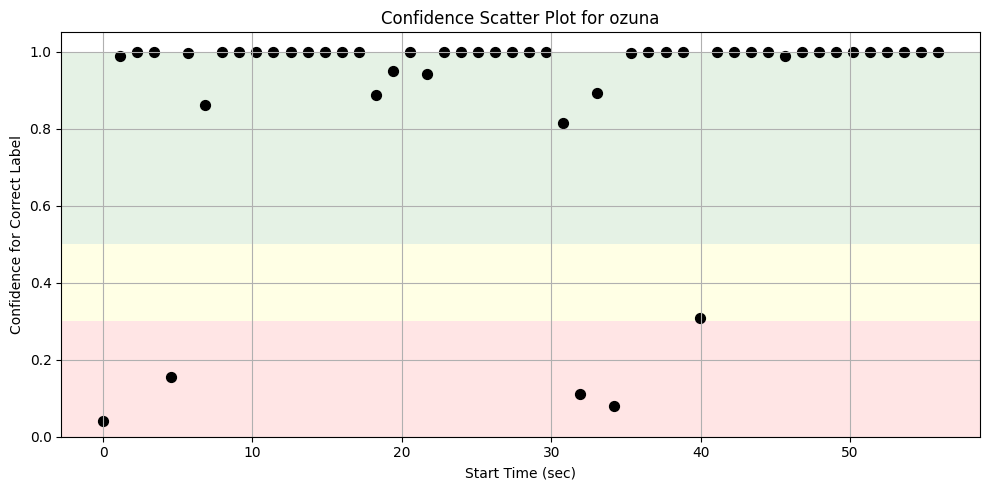

Accuracy (ozuna)：90.0 %

🎧 Evaluating: santana-playing-5.mp3
🟡：santana,	predicted=namiki,	{namiki: 0.57, ozuna: 0.28, santana: 0.10, yamada: 0.04, aoki: 0.01, akahane: 0.01, nishikawa: 0.00, murakami: 0.00, chance5: 0.00, commontheme: 0.00},	0.0
🟢：santana,	predicted=santana,	{santana: 1.00, ozuna: 0.00, yamada: 0.00, aoki: 0.00, chance5: 0.00, nishikawa: 0.00, namiki: 0.00, murakami: 0.00, akahane: 0.00, commontheme: 0.00},	1.0344897959183674
🟢：santana,	predicted=santana,	{santana: 1.00, ozuna: 0.00, yamada: 0.00, chance5: 0.00, aoki: 0.00, namiki: 0.00, nishikawa: 0.00, murakami: 0.00, akahane: 0.00, commontheme: 0.00},	2.068979591836735
🟢：santana,	predicted=santana,	{santana: 0.94, aoki: 0.05, ozuna: 0.00, yamada: 0.00, nishikawa: 0.00, murakami: 0.00, chance5: 0.00, namiki: 0.00, akahane: 0.00, commontheme: 0.00},	3.1034693877551023
🟡：santana,	predicted=ozuna,	{ozuna: 0.98, santana: 0.02, yamada: 0.00, nishikawa: 0.00, aoki: 0.00, akahane: 0.00, chance5: 0.00, namiki: 0.00, murakami

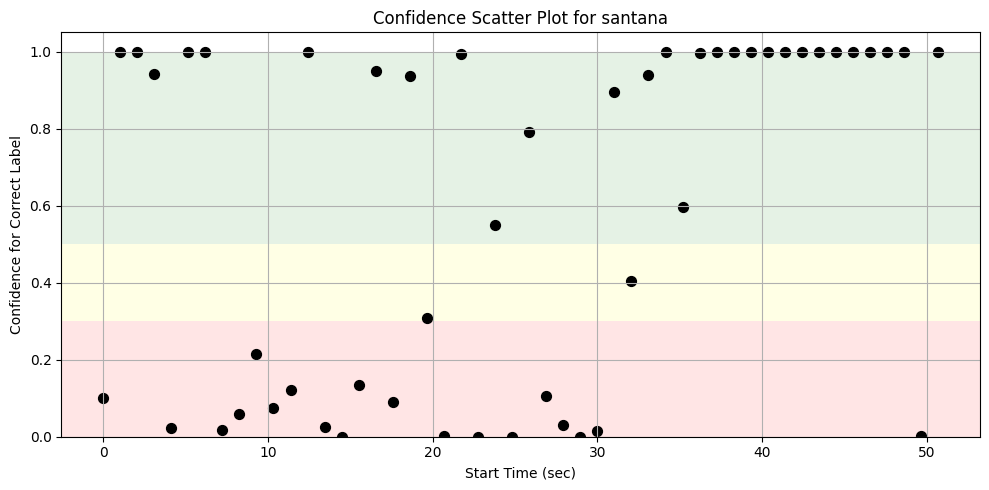

Accuracy (santana)：57.99999999999999 %

🎧 Evaluating: yamada-playing-5.mp3
🟢：yamada,	predicted=yamada,	{yamada: 1.00, murakami: 0.00, ozuna: 0.00, commontheme: 0.00, aoki: 0.00, namiki: 0.00, chance5: 0.00, nishikawa: 0.00, santana: 0.00, akahane: 0.00},	0.0
🟢：yamada,	predicted=yamada,	{yamada: 1.00, ozuna: 0.00, murakami: 0.00, santana: 0.00, aoki: 0.00, nishikawa: 0.00, namiki: 0.00, chance5: 0.00, commontheme: 0.00, akahane: 0.00},	1.7398122448979592
🟢：yamada,	predicted=yamada,	{yamada: 1.00, ozuna: 0.00, santana: 0.00, aoki: 0.00, chance5: 0.00, commontheme: 0.00, murakami: 0.00, namiki: 0.00, akahane: 0.00, nishikawa: 0.00},	3.4796244897959183
🟢：yamada,	predicted=yamada,	{yamada: 1.00, ozuna: 0.00, murakami: 0.00, chance5: 0.00, santana: 0.00, aoki: 0.00, commontheme: 0.00, nishikawa: 0.00, namiki: 0.00, akahane: 0.00},	5.219436734693877
🟡：yamada,	predicted=aoki,	{aoki: 0.96, yamada: 0.03, ozuna: 0.01, santana: 0.00, chance5: 0.00, nishikawa: 0.00, commontheme: 0.00, murakami: 0.0

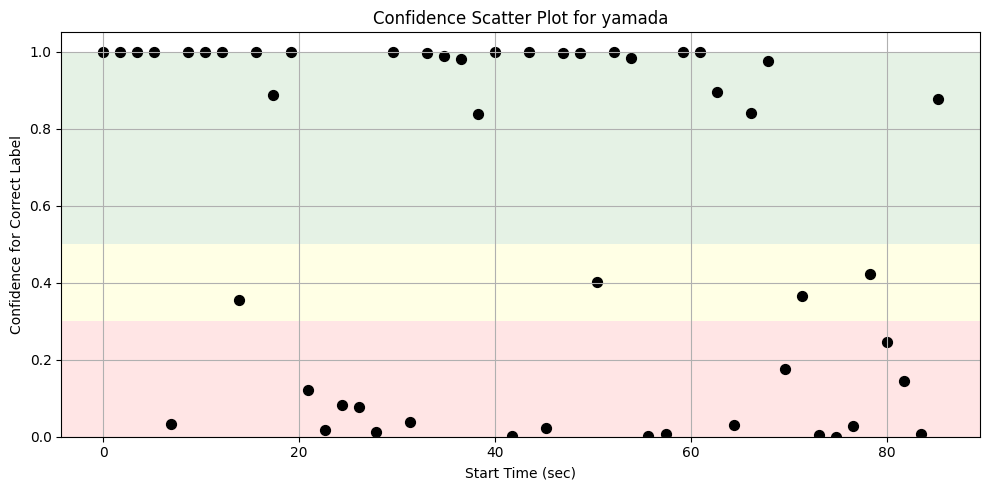

Accuracy (yamada)：56.00000000000001 %

✅ 正解数: 354/500（Accuracy: 70.80%）
❓ unknown 判定回数: 0


In [ ]:
import os
import librosa
import numpy as np
from tqdm import tqdm
from tensorflow.keras.models import load_model

# --- モデルとラベルの読み込み ---

#model_path = "/content/model_filtered.keras"
#model_path = "/content/drive/MyDrive/classifier-ouenka/classifier_ouenka/keras/model_filtered_1000_anchor12_87%.keras"
#model = load_model(model_path)
labels = y_labels
model_input_dim = model.input_shape[1]
confidence_threshold = 0.5

import matplotlib.pyplot as plt

def plot_prediction_confidence_scatter(list_label_t_start, list_label_prob, label_name=""):
    plt.figure(figsize=(10, 5))

    # 背景の色分け
    plt.axhspan(0.5, 1.0, facecolor='green', alpha=0.1, label='Confidence ≥ 0.5')
    plt.axhspan(0.3, 0.5, facecolor='yellow', alpha=0.1, label='0.3 ≤ Confidence < 0.5')
    plt.axhspan(0.0, 0.3, facecolor='red', alpha=0.1, label='Confidence < 0.3')

    # 散布図のプロット
    plt.scatter(list_label_t_start, list_label_prob, color='black', s=50)

    # ラベル・装飾
    plt.xlabel("Start Time (sec)")
    plt.ylabel("Confidence for Correct Label")
    title = f"Confidence Scatter Plot for {label_name}" if label_name else "Confidence Scatter Plot"
    plt.title(title)
    plt.ylim(0, 1.05)
    plt.grid(True)
    plt.tight_layout()
    plt.show()


# --- 予測用ユーティリティ ――――――――――――――――――――――――――― #
def preprocess_segment(audio_path, t_start, sr=44100):
    """
    10 秒クロップ → compute_fp_and_ridges で fp_angle を生成して返す。
    失敗時は None。
    """
    try:
        fp_angle, *_ = compute_fp_and_ridges(
            audio_path,
            t_start=t_start,         # ランダム開始点
            duration=10.0,           # クロップ長さ (sec)
            fmin=2000, fmax=3500,    # 帯域
            grid_shape=(30, 100)     # 出力グリッド (freq×time)
        )
        return fp_angle   # shape = (30, 100), dtype=float32
    except Exception as e:
        print(f"❌ 読み込み失敗: {audio_path} → {e}")
        return None


def predict_segment(fp):
    """
    fp が None のときは unknown。
    モデルの input_shape を見てフラット／グリッドを自動判定して推論。
    """
    if fp is None:
        return "unknown", {label: 0.0 for label in labels}

    # ── モデル入力形状に合わせて reshape ──
    if len(model.input_shape) == 2:          # (None, N) → 1D ベクトル入力
        x_in = fp.reshape(1, -1)
    else:                                    # (None, 30, 100) など → 2D/3D 入力
        x_in = fp.reshape(1, *fp.shape)

    probs = model.predict(x_in, verbose=0)[0]
    pred_dict = {label: float(p) for label, p in zip(labels, probs)}
    pred_label = labels[np.argmax(probs)]
    return pred_label, pred_dict


def decide_label(pred_label, pred_dict, threshold):
    if pred_label not in pred_dict or pred_dict[pred_label] < threshold:
        return "unknown"
    return pred_label

# --- 評価処理 ---
correct = 0
total = 0
unknown_count = 0

samples_per_file = 50  # 各音声からのランダムクロップ数

for label in labels:
    label_total = 0
    label_correct = 0
    list_label_prob, list_label_t_start = [], []
    audio_path = f"/content/drive/MyDrive/classifier-ouenka/classifier_ouenka/test/{label}-playing-5.mp3"

    try:
        y, sr = librosa.load(audio_path, sr=None)
        total_duration = librosa.get_duration(y=y, sr=sr)
        max_start = max(0, total_duration - 10.0)
        t_starts = np.linspace(0, max_start, samples_per_file, endpoint=False)

        print(f"\n🎧 Evaluating: {label}-playing-5.mp3")
        for t_start in t_starts:
            label_total += 1
            fp = preprocess_segment(audio_path, t_start, sr=sr)
            final_label, pred_dict = predict_segment(fp)
            list_label_prob.append(pred_dict[label])
            list_label_t_start.append(t_start)


            proba_str = ', '.join([f"{k}: {v:.2f}" for k, v in sorted(pred_dict.items(), key=lambda item: item[1], reverse=True)])

            if final_label == "unknown":
                unknown_count += 1
                marker = "🟡" if round(pred_dict[label], 2) >= 0.01 else "⚪️"
                print(f"{marker}；{label},\tpredicted={final_label},\t{{{proba_str}}},\t{t_start}")
            else:
                total += 1
                if final_label == label:
                    correct += 1
                    label_correct += 1
                    print(f"🟢：{label},\tpredicted={final_label},\t{{{proba_str}}},\t{t_start}")
                else:
                    marker = "🟡" if round(pred_dict[label], 2) >= 0.01 else "🔴"
                    print(f"{marker}：{label},\tpredicted={final_label},\t{{{proba_str}}},\t{t_start}")

    except Exception as e:
        print(f"❌ ファイル読み込み失敗: {audio_path} → {e}")
    plot_prediction_confidence_scatter(list_label_t_start, list_label_prob, label)
    label_accuracy = label_correct / label_total * 100
    print(f"Accuracy ({label})：{label_accuracy} %")

# --- 集計結果 ---
accuracy = correct / total if total > 0 else 0
print("\n==============================")
print(f"✅ 正解数: {correct}/{total}（Accuracy: {accuracy:.2%}）")
print(f"❓ unknown 判定回数: {unknown_count}")

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
import pandas as pd
import numpy as np

# -------------------------------------------------
# 評価用バッファ
y_true_all, y_pred_all = [], []       # ← 追加
labels_plus_unk = labels + ["unknown"]  # confusion 行列の並び

samples_per_file = 50
confidence_threshold = 0.5

for label in labels:
    label_total = label_correct = 0
    list_label_prob, list_label_t_start = [], []
    audio_path = f"/content/drive/MyDrive/classifier-ouenka/classifier_ouenka/test/{label}-playing-5.mp3"

    try:
        y, sr = librosa.load(audio_path, sr=None)
        total_duration = librosa.get_duration(y=y, sr=sr)
        max_start = max(0, total_duration - 10.0)
        t_starts = np.random.uniform(0, max_start, samples_per_file)

        for t_start in t_starts:
            fp = preprocess_segment(audio_path, t_start)
            pred_label, pred_dict = predict_segment(fp)

            # --------- confusion 用 ----------
            final_label = decide_label(pred_label, pred_dict, confidence_threshold)
            y_true_all.append(label)
            y_pred_all.append(final_label)
            # ----------------------------------

            list_label_prob.append(pred_dict[label])
            list_label_t_start.append(t_start)


    except Exception as e:
        print(f"❌ ファイル読み込み失敗: {audio_path} → {e}")

# -------------------------------------------------
# ① confusion matrix を計算
cm = confusion_matrix(y_true_all, y_pred_all, labels=labels_plus_unk)

# ② DataFrame にしてラベル付きヒートマップ
cm_df = pd.DataFrame(cm, index=labels_plus_unk, columns=labels_plus_unk)

plt.figure(figsize=(10, 8))
sns.heatmap(cm_df, annot=True, fmt="d", cmap="Blues")
plt.ylabel("True Label")
plt.xlabel("Predicted Label")
plt.title("Confusion Matrix (500 crops per file)")
plt.tight_layout()
plt.show()


# test

In [ ]:
import IPython.display as display
from google.colab import output
from base64 import b64decode
import uuid

def record_audio_colab(filename='recorded.webm'):
    print("マイクの許可をしてください。")
    RECORD = """
    const sleep = time => new Promise(resolve => setTimeout(resolve, time))
    const b2text = blob => new Promise(resolve => {
      const reader = new FileReader();
      reader.onloadend = () => resolve(reader.result);
      reader.readAsDataURL(blob);
    });

    var record = async () => {
      const stream = await navigator.mediaDevices.getUserMedia({ audio: true });
      const mediaRecorder = new MediaRecorder(stream);
      const audioChunks = [];

      mediaRecorder.ondataavailable = e => audioChunks.push(e.data);
      mediaRecorder.start();

      await sleep(12000);  // 録音時間（ms）

      mediaRecorder.stop();

      await new Promise(resolve => mediaRecorder.onstop = resolve);
      const audioBlob = new Blob(audioChunks);
      const base64 = await b2text(audioBlob);
      return base64;
    };

    record().then(base64 => {
      google.colab.kernel.invokeFunction('notebook.save_audio', [base64], {});
    });
    """
    display.display(display.Javascript(RECORD))

from base64 import b64decode

def save_audio(base64_audio, filename='recorded-.webm'):
    audio_data = b64decode(base64_audio.split(',')[1])
    with open(filename, 'wb') as f:
        f.write(audio_data)
    print(f"✅ 録音保存完了: {filename}")

# コールバック登録
output.register_callback('notebook.save_audio', lambda b: save_audio(b, 'recorded.webm'))
from pydub import AudioSegment

import subprocess

def convert_webm_to_mp3(webm_path='recorded.webm', mp3_path='recorded.mp3'):
    try:
        command = ['ffmpeg', '-y', '-i', webm_path, mp3_path]
        subprocess.run(command, check=True)
        print("✅ MP3変換完了:", mp3_path)
        return mp3_path
    except subprocess.CalledProcessError as e:
        print("❌ ffmpeg 変換エラー:", e)
        return None


def run_prediction_pipeline():
    model_input_dim = model.input_shape[1]
    mp3_path = 'recorded.mp3'

    y, sr = librosa.load(audio_path, sr=None)
    fp = preprocess_segment(mp3_path, t_start=0, sr=sr)
    final_label, pred_dict = predict_segment(fp)

    #pred_label, pred_dict = predict_with_majority_voting(mp3_path, model, model_input_dim)
    #final_label = decide_label_with_thresholds(pred_label, pred_dict, confidence_threshold=0.5)

    print("\n🎧 予測結果:")
    for label, prob in sorted(pred_dict.items(), key=lambda x: x[1], reverse=True):
        print(f"{label}: {prob:.2f}")
    print("🔮 最終ラベル:", final_label)

In [ ]:
record_audio_colab()

マイクの許可をしてください。


<IPython.core.display.Javascript object>

✅ 録音保存完了: recorded.webm


In [ ]:
display.display(display.Audio('recorded.webm'))

In [ ]:
mp3_path = convert_webm_to_mp3('recorded.webm', 'recorded.mp3')

✅ MP3変換完了: recorded.mp3


In [ ]:
display.display(display.Audio('recorded.webm'))

In [ ]:
run_prediction_pipeline()

✅ MP3変換完了: recorded.mp3

🎧 予測結果:
yamada: 0.71
namiki: 0.18
chance5: 0.10
ozuna: 0.02
aoki: 0.00
murakami: 0.00
nishikawa: 0.00
santana: 0.00
commontheme: 0.00
akahane: 0.00
🔮 最終ラベル: yamada


# Pytorch

In [ ]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import LabelEncoder
import pickle

# --- train/test 分割 ---
X_train, X_test, y_train, y_test = train_test_split(X, y_categorical, test_size=0.2, random_state=42)

# --- Tensor型に変換（float32 + one-hot）---
X_train = torch.tensor(X_train, dtype=torch.float32)
X_test  = torch.tensor(X_test , dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.float32)
y_test  = torch.tensor(y_test , dtype=torch.float32)

# --- ResNetブロック（Kerasと同じ構成） ---
class SimpleResNetBlock(nn.Module):
    def __init__(self, units):
        super().__init__()
        self.fc1 = nn.Linear(units, units)
        self.fc2 = nn.Linear(units, units)

    def forward(self, x):
        identity = x
        out = F.relu(self.fc1(x))
        out = self.fc2(out)
        return F.relu(out + identity)

# --- ResNetサブネットモデル（Kerasと同じ構造） ---
class ResNetSubNetModel(nn.Module):
    def __init__(self, input_dim, n_classes, n_splits=9):
        super().__init__()
        self.n_splits = n_splits
        self.split_size = input_dim // n_splits
        self.subnets = nn.ModuleList([
            nn.Sequential(
                nn.Linear(self.split_size, 256),
                nn.ReLU(),
                SimpleResNetBlock(256),
                nn.Linear(256, 64),
                nn.ReLU()
            ) for _ in range(n_splits)
        ])
        self.fc1 = nn.Linear(64 * n_splits, 128)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(128, n_classes)
        self.softmax = nn.Softmax(dim=1)

    def forward(self, x):
        splits = torch.split(x, self.split_size, dim=1)
        sub_outputs = [subnet(s) for subnet, s in zip(self.subnets, splits)]
        x = torch.cat(sub_outputs, dim=1)
        x = self.relu(self.fc1(x))
        x = self.softmax(self.fc2(x))
        return x

# --- モデル初期化 ---
model = ResNetSubNetModel(input_dim=X.shape[1], n_classes=len(y_labels))
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
criterion = nn.BCELoss()

# --- 学習ループ ---
epochs = 20
batch_size = 32
for epoch in range(epochs):
    model.train()
    permutation = torch.randperm(X_train.size(0))
    epoch_preds = []
    epoch_trues = []

    for i in range(0, X_train.size(0), batch_size):
        indices = permutation[i:i+batch_size]
        batch_x, batch_y = X_train[indices], y_train[indices]

        optimizer.zero_grad()
        outputs = model(batch_x)
        loss = criterion(outputs, batch_y)
        loss.backward()
        optimizer.step()

        # Accuracy計算用
        preds = torch.argmax(outputs, dim=1)
        trues = batch_y
        epoch_preds.append(preds.cpu())
        epoch_trues.append(trues.cpu())

    # 全バッチ結合して Accuracy 計算
        all_preds = torch.cat(epoch_preds)
        all_trues = torch.cat(epoch_trues)
        acc = accuracy_score(torch.argmax(all_trues, dim=1).numpy(), all_preds.numpy())



    # --- テスト精度評価 ---
model.eval()
with torch.no_grad():
    test_outputs = model(X_test)
    pred_indices = torch.argmax(test_outputs, dim=1)
    true_indices = torch.argmax(y_test, dim=1)
    acc = accuracy_score(true_indices.numpy(), pred_indices.numpy())
    print(f"Epoch {epoch+1}/{epochs}, Test Accuracy: {acc:.4f}")

# --- モデル情報保存（pkl） ---
info = {
    "input_dim": X.shape[1],
    "n_classes": len(y_labels),
    "y_labels": y_labels
}
with open("/content/pytorch_model.pkl", "wb") as f:
    pickle.dump(info, f)

# --- モデルの重み保存（pt） ---
torch.save(model.state_dict(), "/content/model_state.pt")
print("✅ TensorFlow構成と完全一致したPyTorchモデルを保存しました。")

import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import pickle
import librosa
from scipy.signal import convolve2d
from skimage import measure

# --- モデル情報と重みの読み込み ---
with open("/content/pytorch_model.pkl", "rb") as f:
    info = pickle.load(f)

input_dim = info["input_dim"]
n_classes = info["n_classes"]
labels = info["y_labels"]

model = ResNetSubNetModel(input_dim=input_dim, n_classes=n_classes)
model.load_state_dict(torch.load("/content/model_state.pt"))
model.eval()

# --- 特徴量抽出 ---
def visualize_region_grid(audio_path, t_start, role, duration=10.0, fmin=2000, fmax=3500,
                          kernel_size=(30, 15), region_threshold=1.0, min_region_size=(5, 15),
                          n_fft=2048, hop_length=512, grid_shape=(30, 100)):
    y_full, sr = librosa.load(audio_path, sr=None)
    y = y_full[int(t_start * sr):int((t_start + duration) * sr)]
    y = y / (np.max(np.abs(y)) + 1e-9)

    S = librosa.stft(y, n_fft=n_fft, hop_length=hop_length)
    S_db = librosa.amplitude_to_db(np.abs(S), ref=np.max)
    freqs = librosa.fft_frequencies(sr=sr, n_fft=n_fft)
    mask = (freqs >= fmin) & (freqs <= fmax)
    S_db_band = S_db[mask, :]

    mu, sigma = S_db_band.mean(), S_db_band.std() + 1e-9
    S_norm = (S_db_band - mu) / sigma * np.sqrt(2.0)
    S_blur = convolve2d(S_norm, np.ones(kernel_size) / np.prod(kernel_size), mode="same", boundary="symm")
    S_diff = S_norm - S_blur
    binary = (S_diff > region_threshold).astype(np.uint8)

    labeled = measure.label(binary)
    props = measure.regionprops(labeled)
    valid = [p.label for p in props if (p.bbox[2] - p.bbox[0]) >= min_region_size[0] and (p.bbox[3] - p.bbox[1]) >= min_region_size[1]]
    filtered = np.isin(labeled, valid).astype(np.uint8)

    rows, cols = grid_shape
    h, w = filtered.shape
    block_h = h / rows
    block_w = w / cols
    grid = np.zeros((rows, cols), dtype=np.uint8)
    for i in range(rows):
        for j in range(cols):
            y0, y1 = int(i * block_h), int((i + 1) * block_h)
            x0, x1 = int(j * block_w), int((j + 1) * block_w)
            if filtered[y0:y1, x0:x1].any():
                grid[i, j] = 1
    return grid

def anchor_fingerprint(grid: np.ndarray, anchor: tuple) -> np.ndarray:
    i0, j0 = anchor
    ref_val = grid[i0, j0]
    rows, cols = grid.shape
    codes = (ref_val << 1) | grid
    fingerprint = np.delete(codes.ravel(), i0 * cols + j0).astype(np.uint8)
    return fingerprint

def anchor_fingerprint_all(grid: np.ndarray) -> np.ndarray:
    anchors = [
        (5, 10), (5, 35), (5, 65), (5, 90),
        (15, 10), (15, 35), (15, 65), (15, 90),
        (25, 10), (25, 35), (25, 65), (25, 90),
    ]
    result = []
    for anchor in anchors:
        fp = anchor_fingerprint(grid, anchor)
        result.append(fp.astype(np.float32))
    return np.concatenate(result).reshape(1, -1)

# --- 推論関数（softmax済みの出力を返す） ---
def predict_audio(audio_path):
    try:
        grid = visualize_region_grid(audio_path, t_start=0.0, role="test")
        feat = anchor_fingerprint_all(grid)
        feat_tensor = torch.tensor(feat, dtype=torch.float32)
        with torch.no_grad():
            probs = model(feat_tensor).squeeze().numpy()
            pred_index = np.argmax(probs)
            pred_label = labels[pred_index]
            prob_dict = {label: float(probs[i]) for i, label in enumerate(labels)}
            return pred_label, prob_dict
    except Exception as e:
        print(f"Error processing {audio_path}: {e}")
        return "unknown", {label: 0.0 for label in labels}

# --- しきい値でunknown化 ---
def decide_label_with_thresholds(pred_label, pred_dict, threshold=0.5):
    if pred_dict[pred_label] < threshold:
        return "unknown"
    return pred_label
import os
import librosa
import numpy as np
from tqdm import tqdm
from tensorflow.keras.models import load_model

# --- モデルとラベルの読み込み ---
labels = y_labels
model_input_dim = model.input_shape[1]
confidence_threshold = 0.5

import matplotlib.pyplot as plt

def plot_prediction_confidence_scatter(list_label_t_start, list_label_prob, label_name=""):
    plt.figure(figsize=(10, 5))

    # 背景の色分け
    plt.axhspan(0.5, 1.0, facecolor='green', alpha=0.1, label='Confidence ≥ 0.5')
    plt.axhspan(0.3, 0.5, facecolor='yellow', alpha=0.1, label='0.3 ≤ Confidence < 0.5')
    plt.axhspan(0.0, 0.3, facecolor='red', alpha=0.1, label='Confidence < 0.3')

    # 散布図のプロット
    plt.scatter(list_label_t_start, list_label_prob, color='black', s=50)

    # ラベル・装飾
    plt.xlabel("Start Time (sec)")
    plt.ylabel("Confidence for Correct Label")
    title = f"Confidence Scatter Plot for {label_name}" if label_name else "Confidence Scatter Plot"
    plt.title(title)
    plt.ylim(0, 1.05)
    plt.grid(True)
    plt.tight_layout()
    plt.show()


# --- 予測用ユーティリティ ---
def preprocess_segment(audio_path, t_start, sr=44100):
    try:
        y, _ = librosa.load(audio_path, sr=sr)
        start_sample = int(t_start * sr)
        end_sample = int((t_start + 10.0) * sr)
        segment = y[start_sample:end_sample]
        if len(segment) < sr * 10:
            segment = np.pad(segment, (0, sr * 10 - len(segment)), mode='constant')
        segment_path = audio_path  # visualize関数は内部でloadし直すため元path渡す
        grid = visualize_region_grid(segment_path, t_start=t_start, role="test")
        fp = anchor_fingerprint_all(grid)
        return fp
    except Exception as e:
        print(f"❌ 読み込み失敗: {audio_path} → {e}")
        return None

def predict_segment(fp):
    if fp is None:
        return "unknown", {label: 0.0 for label in labels}
    fp = fp.reshape(1, -1)
    probs = model.predict(fp, verbose=0)[0]
    pred_dict = {label: float(p) for label, p in zip(labels, probs)}
    pred_label = labels[np.argmax(probs)]
    return pred_label, pred_dict

def decide_label(pred_label, pred_dict, threshold):
    if pred_label not in pred_dict or pred_dict[pred_label] < threshold:
        return "unknown"
    return pred_label

# --- 評価処理 ---
correct = 0
total = 0
unknown_count = 0

samples_per_file = 500  # 各音声からのランダムクロップ数

for label in labels:
    label_total = 0
    label_correct = 0
    list_label_prob, list_label_t_start = [], []
    audio_path = f"/content/drive/MyDrive/classifier-ouenka/classifier_ouenka/test/{label}-playing-5.mp3"

    try:
        y, sr = librosa.load(audio_path, sr=None)
        total_duration = librosa.get_duration(y=y, sr=sr)
        max_start = max(0, total_duration - 10.0)
        t_starts = np.random.uniform(0, max_start, samples_per_file)

        print(f"\n🎧 Evaluating: {label}-playing-5.mp3")
        for t_start in t_starts:
            label_total += 1
            fp = preprocess_segment(audio_path, t_start, sr=sr)
            final_label, pred_dict = predict_segment(fp)
            list_label_prob.append(pred_dict[label])
            list_label_t_start.append(t_start)


            proba_str = ', '.join([f"{k}: {v:.2f}" for k, v in sorted(pred_dict.items(), key=lambda item: item[1], reverse=True)])

            if final_label == "unknown":
                unknown_count += 1
                marker = "🟡" if round(pred_dict[label], 2) >= 0.01 else "⚪️"
                #print(f"{marker}；{label},\tpredicted={final_label},\t{{{proba_str}}},\t{t_start}")
            else:
                total += 1
                if final_label == label:
                    correct += 1
                    label_correct += 1
                    #print(f"🟢：{label},\tpredicted={final_label},\t{{{proba_str}}},\t{t_start}")
                else:
                    marker = "🟡" if round(pred_dict[label], 2) >= 0.01 else "🔴"
                    #print(f"{marker}：{label},\tpredicted={final_label},\t{{{proba_str}}},\t{t_start}")

    except Exception as e:
        print(f"❌ ファイル読み込み失敗: {audio_path} → {e}")
    plot_prediction_confidence_scatter(list_label_t_start, list_label_prob, label)
    label_accuracy = label_correct / label_total * 100
    print(f"Accuracy ({label})：{label_accuracy} %")

# --- 集計結果 ---
accuracy = correct / total if total > 0 else 0
print("\n==============================")
print(f"✅ 正解数: {correct}/{total}（Accuracy: {accuracy:.2%}）")
print(f"❓ unknown 判定回数: {unknown_count}")